# Principle Coordinates Analysis

This notebook handles generation of PCoA figures and corresponding analyses

## Data wrangling

In [1]:
# "jupyter shell" function from https://stackoverflow.com/a/50259241/7146785
sh <- function(shell_command){
    cat(system(shell_command, intern=TRUE), sep='\n')
}

#### DM filepaths

In [2]:
sh('ls ../bdiv')

filtered_dist
jaccard.merged-table.in-map.nomito-nochloro.10k.qza
jaccard.merged-table.in-map.nomito-nochloro.5k.qza
unifrac_unw.merged-table.in-map.nomito-nochloro.10k.qza
unifrac_unw.merged-table.in-map.nomito-nochloro.10k.tsv
unifrac_unw.merged-table.in-map.nomito-nochloro.5k.qza
unifrac_w.merged-table.in-map.nomito-nochloro.10k.qza
unifrac_w.merged-table.in-map.nomito-nochloro.5k.qza


In [3]:
sh('ls ../bdiv/filtered_dist/')

emperor
jaccard.5k.5per.qza
unifrac_unw.10k.5per_amphibians.qza
unifrac_unw.10k.5per_amphibians.tsv
unifrac_unw.10k.5per_birds_fecal.qza
unifrac_unw.10k.5per_birds_fecal.tsv
unifrac_unw.10k.5per_birds_intestinal.qza
unifrac_unw.10k.5per_birds_intestinal.tsv
unifrac_unw.10k.5per_birds.qza
unifrac_unw.10k.5per_birds.tsv
unifrac_unw.10k.5per_mammals.qza
unifrac_unw.10k.5per_mammals.tsv
unifrac_unw.10k.5per.pcoa.qza
unifrac_unw.10k.5per.qza
unifrac_unw.10k.5per_reptiles.qza
unifrac_unw.10k.5per_reptiles.tsv
unifrac_unw.10k.5per.tsv
unifrac_unw.5k.5per.pcoa.qza
unifrac_unw.5k.5per.qza
unifrac_w.5k.5per.qza


In [4]:
sh('ls ../bdiv/filtered_dist/emperor/')

unifrac_unw.10k.5per.qzv
unifrac_unw.5k.5per.qzv


## calculate PCoAs

In [5]:
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(tidyverse)
require(qiime2R)
require(cowplot)

Loading required package: ggplot2
Loading required package: vegan
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-3
Loading required package: RColorBrewer
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.0.1     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.3.1     ✔ stringr 1.3.1
✔ tibble  2.0.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: qiime2R
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



### Define color tables

In [6]:
class_colors <- c("Cephalochordata" = "#a6cee3",
                  "Petromyzontida" = "#a6cee3",
                  "Actinopteri" = "#1f78b4",
                  "Amphibia" = "#b2df8a",
                  "Chelonia" = "#33a02c",
                  "Lepidosauria" = "#fb9a99",
                  "Crocodylomorpha" = "#e31a1c",
                  "Aves" = "#EACB47",
                  "Mammalia" = "#6a3d9a",
                  "Mammalia_Chiroptera" = "#6a3d9a")

#### Load metadata

In [7]:
md.fp <- '../metadata//eco_md-qiime_host_species_eco_metadata_by_SampleID_gut_2.18.19.txt'
md <- read_tsv(md.fp)

Parsed with column specification:
cols(
  .default = col_double(),
  SampleID = col_character(),
  Orig_ID = col_character(),
  BarcodeSequence = col_character(),
  LinkerPrimerSequence = col_character(),
  extracted = col_character(),
  sequenced_se = col_character(),
  sequenced_pe = col_character(),
  lane_primerplate = col_character(),
  lane = col_character(),
  OldSampleID = col_character(),
  Sample = col_character(),
  sample_type = col_character(),
  preservative = col_character(),
  sex = col_character(),
  healthy = col_character(),
  captive_wild = col_character(),
  LIFE_STAGE = col_character(),
  barcodeID = col_character(),
  dataset = col_character(),
  collector = col_character()
  # ... with 116 more columns
)
See spec(...) for full column specifications.
Warning message:
“499 parsing failures.
 row                          col           expected actual                                                                              file
1800 MV.female_svl_at_maturity_cm 

Make a bats category

In [8]:
md$is_bat = FALSE
md$is_bat[md['Taxonomy_Order'] == 'Chiroptera'] = TRUE

md$Taxonomy_Class_bat = md$Taxonomy_Class
md$Taxonomy_Class_bat[md$is_bat] = 'Mammalia_Chiroptera'

Clean up diet categories

In [9]:
md$Diet.Fruit <- md$ET.Diet.Fruit
md$Diet.Nect <- md$ET.Diet.Nect
md$Diet.Inv <- md$ET.Diet.Inv
md$Diet.Plant <- md$ET.Diet.PlantO
md$Diet.Seed <- md$ET.Diet.Seed
md$Diet.Scav <- md$ET.Diet.Scav
md$Diet.Meat <- md$ET.Diet.Vect + md$ET.Diet.Vend + md$ET.Diet.Vfish + md$ET.Diet.Vunk

md$NA.diet <- md %>% select(starts_with('Diet')) %>% rowSums %>% is.na

#### Load PCoA 

In [10]:
uni_unw.pc.fp <- '../bdiv/filtered_dist/unifrac_unw.5k.5per.pcoa.qza'

In [11]:
uni_unw.pc <- read_qza(uni_unw.pc.fp)

#### Output files

In [12]:
outdir = '../pcoa_figs'

dir.create(file.path(outdir), showWarnings = FALSE)

#### Full dataset

PC1 and PC2, unweighted UniFrac, colored by class:

Warning message:
“Column `SampleID` joining factor and character vector, coercing into character vector”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

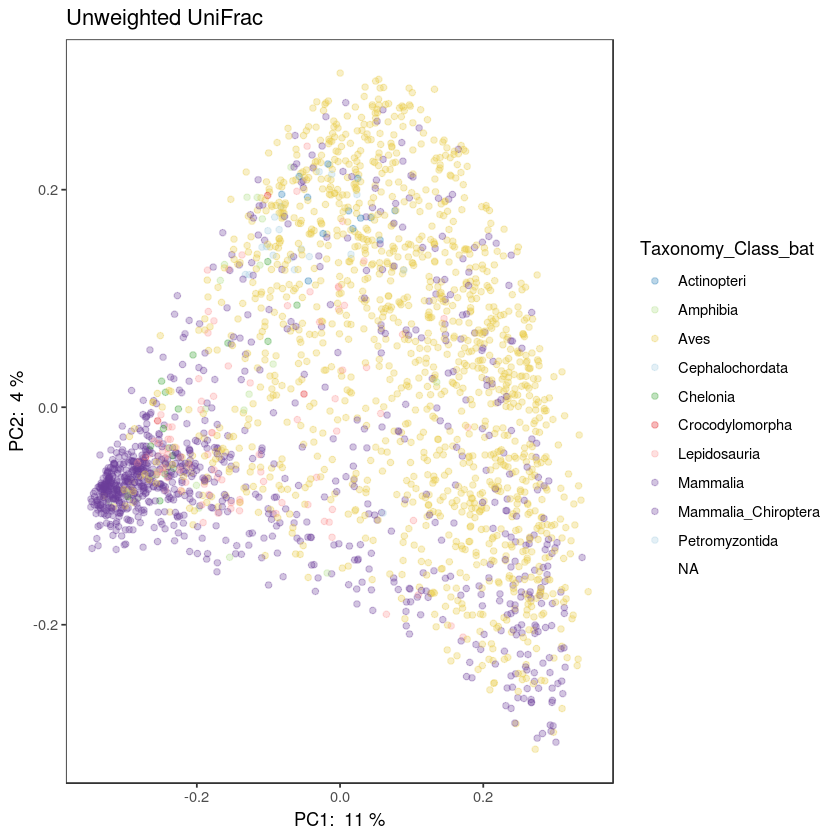

In [13]:
pc_all <- uni_unw.pc$data$Vectors %>% 
  left_join(md, by='SampleID') %>%
  ggplot(aes(x=PC1, y=PC2, color=Taxonomy_Class_bat)) +
  geom_point(alpha=0.3) +
  xlab(paste("PC1: ", round(100*uni_unw.pc$data$ProportionExplained[1]), "%")) +
  ylab(paste("PC2: ", round(100*uni_unw.pc$data$ProportionExplained[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_color_manual(values=class_colors) +
  ggtitle("Unweighted UniFrac")

ggsave(pc_all, filename=file.path(outdir, 'pcoa.unifrac.color-class.pdf'),
       width=12, height=8)

pc_all

Warning message:
“Column `SampleID` joining factor and character vector, coercing into character vector”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

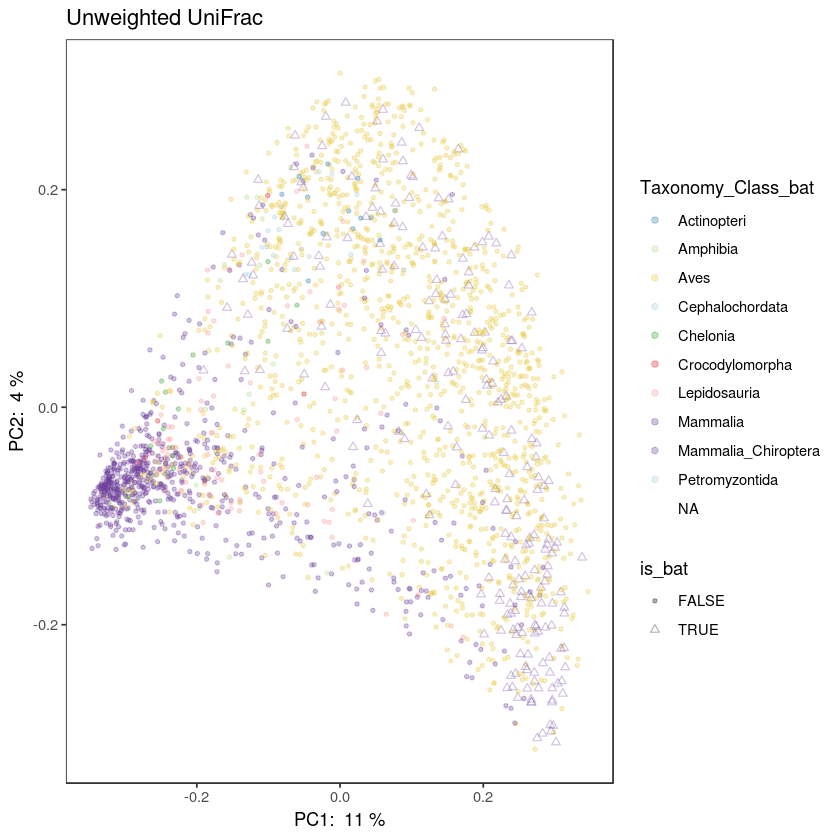

In [14]:
pc_all_batshape <- uni_unw.pc$data$Vectors %>% 
  left_join(md, by='SampleID') %>%
  ggplot(aes(x=PC1, y=PC2, color=Taxonomy_Class_bat)) +
  geom_point(alpha=0.3, aes(shape=is_bat)) +
  xlab(paste("PC1: ", round(100*uni_unw.pc$data$ProportionExplained[1]), "%")) +
  ylab(paste("PC2: ", round(100*uni_unw.pc$data$ProportionExplained[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_color_manual(values=class_colors) +
  scale_shape_manual(values=c(20, 2)) +
  ggtitle("Unweighted UniFrac")

ggsave(pc_all_batshape, filename=file.path(outdir, 'pcoa.unifrac.color-class.shape-bats.pdf'),
       width=12, height=8)

pc_all_batshape

Plot with ellipses:

Warning message:
“Column `SampleID` joining factor and character vector, coercing into character vector”Warning message:
“Removed 52 rows containing missing values (geom_path).”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 52 rows containing missing values (geom_path).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

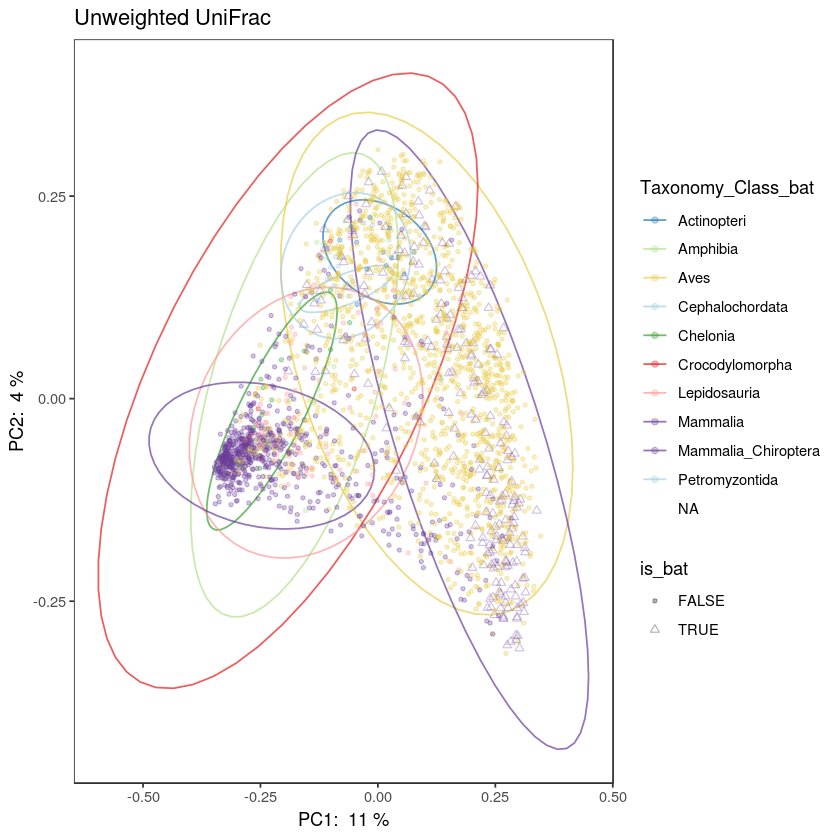

In [15]:
pc_all_batshape_ellipse <- uni_unw.pc$data$Vectors %>% #rename to match the metadata table
  left_join(md, by='SampleID') %>%
  ggplot(aes(x=PC1, y=PC2, color=Taxonomy_Class_bat)) +
  stat_ellipse(alpha=0.7) +
  geom_point(alpha=0.3, aes(shape=is_bat)) +
  xlab(paste("PC1: ", round(100*uni_unw.pc$data$ProportionExplained[1]), "%")) +
  ylab(paste("PC2: ", round(100*uni_unw.pc$data$ProportionExplained[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_color_manual(values=class_colors) +
  scale_shape_manual(values=c(20, 2)) +
  ggtitle("Unweighted UniFrac")

ggsave(pc_all_batshape_ellipse,
       filename=file.path(outdir, 'pcoa.unifrac.color-class.shape-bats.ellipse.pdf'),
       width=12, height=8)

pc_all_batshape_ellipse

Removing crocodylomorphs, for which we just have a few samples:

Warning message:
“Column `SampleID` joining factor and character vector, coercing into character vector”

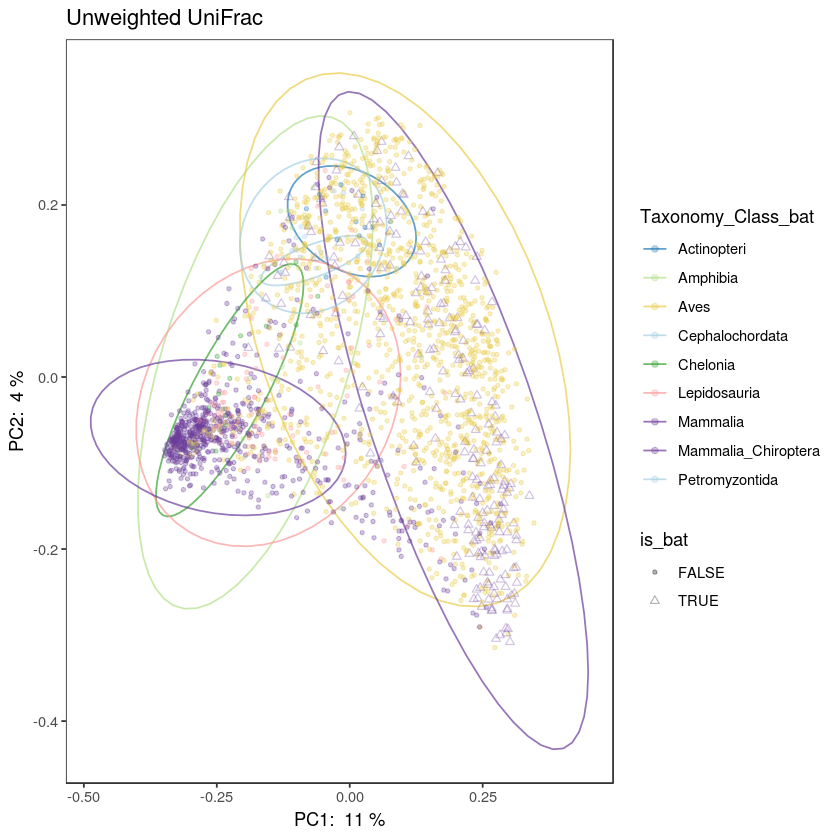

In [16]:
pc_all_batshape_ellipse <- uni_unw.pc$data$Vectors %>% #rename to match the metadata table
  left_join(md, by='SampleID') %>%
  subset(Taxonomy_Class != "Crocodylomorpha") %>%
  ggplot(aes(x=PC1, y=PC2, color=Taxonomy_Class_bat)) +
  stat_ellipse(alpha=0.7) +
  geom_point(alpha=0.3, aes(shape=is_bat)) +
  xlab(paste("PC1: ", round(100*uni_unw.pc$data$ProportionExplained[1]), "%")) +
  ylab(paste("PC2: ", round(100*uni_unw.pc$data$ProportionExplained[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_color_manual(values=class_colors) +
  scale_shape_manual(values=c(20, 2)) +
  ggtitle("Unweighted UniFrac")


ggsave(pc_all_batshape_ellipse,
       filename=file.path(outdir, 'pcoa.unifrac.color-class.shape-bats.ellipse.nocroc.pdf'),
       width=8, height=6)

pc_all_batshape_ellipse

#### Mammals only

In [17]:
mammal_dm_fp = '../bdiv/filtered_dist/unifrac_unw.10k.5per_mammals.qza'
mammal_dm <- read_qza(mammal_dm_fp)

In [252]:
m <- cmdscale(mammal_dm$data, k=5, eig=TRUE)
pcts <- m$eig / sum(m$eig[m$eig > 0])

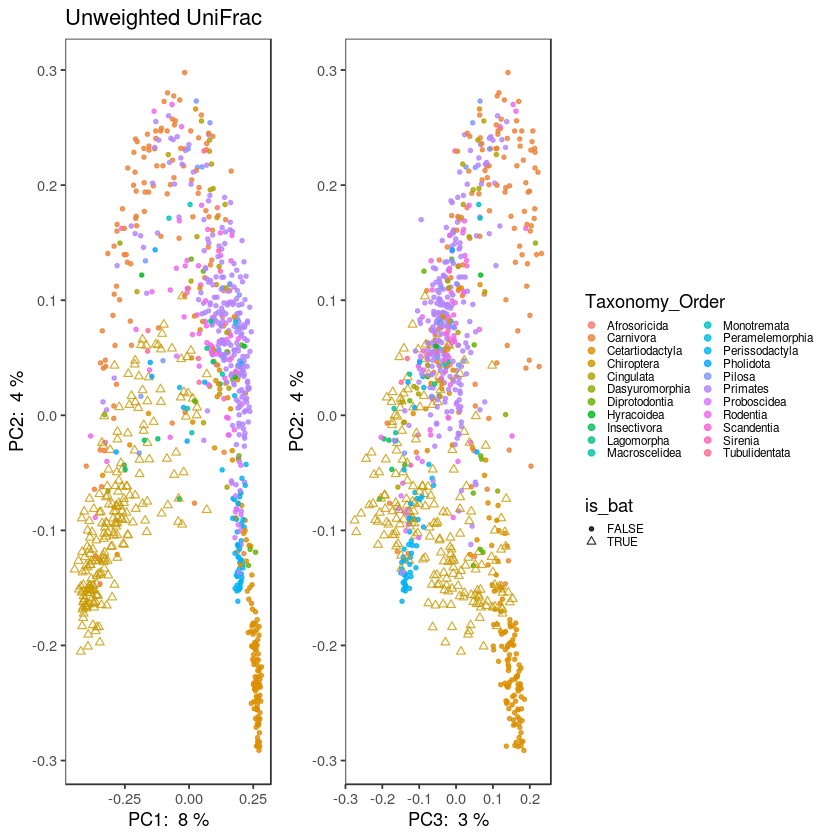

In [286]:
mammal_pcoa <- m$points %>% as.data.frame %>% rownames_to_column %>%
  left_join(md, by=c('rowname'='SampleID'))


m_pc1 <- ggplot(mammal_pcoa, aes(x=V1, y=V2, color=Taxonomy_Order)) +
  geom_point(alpha=0.8, aes(shape=is_bat)) +
  xlab(paste("PC1: ", round(100*pcts[1]), "%")) +
  ylab(paste("PC2: ", round(100*pcts[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_shape_manual(values=c(20, 2)) +
  ggtitle("Unweighted UniFrac")

m_pc2 <- ggplot(mammal_pcoa, aes(x=V3, y=V2, color=Taxonomy_Order)) +
  geom_point(alpha=0.8, aes(shape=is_bat)) +
  xlab(paste("PC3: ", round(100*pcts[3]), "%")) +
  ylab(paste("PC2: ", round(100*pcts[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_shape_manual(values=c(20, 2))

m_panels <- plot_grid(m_pc1 + theme(legend.position='none',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank()),
                    m_pc2 + theme(legend.position='none',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank()),
                    NULL,
                    align='vh',
                    nrow=1)

m_legend <- get_legend(m_pc1 + theme(legend.position='right',
                                 legend.justification='right',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank(),
                                legend.text = element_text(size=7),
                                legend.key.size = unit(0.1, "in")))

mam_pc <- m_panels + draw_grob(m_legend, 2.2/3, .4, .2, .2, scale=0.5)

save_plot('../pcoa_figs/pcoa.unifrac.color-order.mammals.pc1-3.pdf',
          mam_pc, 
          base_aspect_ratio = 3)

mam_pc

In [186]:
mammal_pcoa_diet <- mammal_pcoa %>% select(starts_with('Diet'),
                                           starts_with('Taxonomy'),
                                           NA.diet,
                                           is_bat,
                                           V1:V5)

In [197]:
diet_colors <- c('#a6cee3',
                 '#1f78b4',
                 '#33a02c',
                 '#b2df8a',
                 '#cab2d6',
                 '#6a3d9a',
                 '#e31a1c') 

diets <- c('Diet.Fruit',
           'Diet.Nect',
           'Diet.Plant',
           'Diet.Seed',
           'Diet.Inv',
           'Diet.Scav',
           'Diet.Meat')

In [289]:
diet_cowplot <- function(pcoa_df, pcts, cats, colors) {
    plots = list()
    for (i in seq_along(cats)) local({
        i <- i
        p <- ggplot(subset(pcoa_df, NA.diet==FALSE),
                           aes_string(x='V1', y='V2', color=cats[i])) +
                      geom_point(aes(shape=is_bat), alpha=0.6) +
                      theme_bw() + 
                      theme(panel.grid=element_blank()) +
                      scale_shape_manual(values=c(20, 2)) +
                      ggtitle(cats[i]) +
                      scale_alpha(range=c(0.04, 1)) +
                      scale_color_distiller(palette='YlGnBu') +
                      theme(legend.position = "none",
                            axis.text = element_blank(),
                            axis.title=element_blank(),
                            panel.background=element_rect(fill = "black"))
        plots[[i]] <<- p
    })
    plot <- plot_grid(plotlist=plots, nrow=3, ncol=3)
    return(plot)
}

In [290]:
m_diet_plot <- diet_cowplot(mammal_pcoa_diet,
             pcts,
             diets,
             diet_colors)

In [295]:
?save_plot

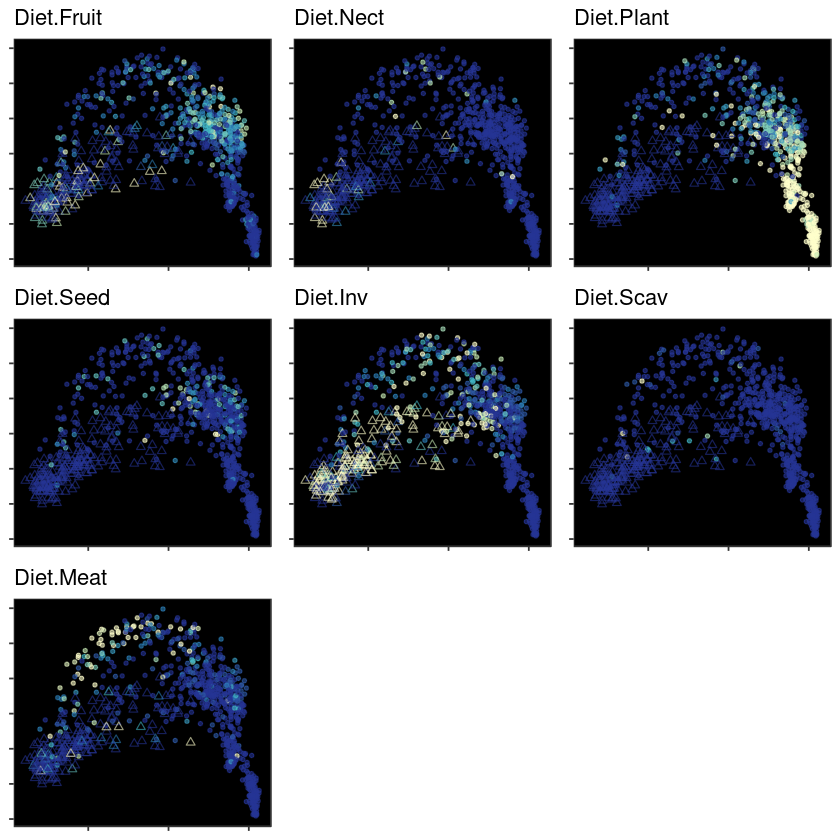

In [297]:
save_plot('../pcoa_figs/pcoa.unifrac.color-diet.mammals.pdf',
          m_diet_plot, 
          base_aspect_ratio = 1,
          base_width=8,
          base_height=8)

m_diet_plot

#### Birds only

#### Mammals only

In [234]:
bird_dm_fp = '../bdiv/filtered_dist/unifrac_unw.10k.5per_birds.qza'
bird_dm <- read_qza(bird_dm_fp)

In [254]:
b <- cmdscale(bird_dm$data, k=5, eig=TRUE)
pcts <- b$eig / sum(b$eig[b$eig > 0])

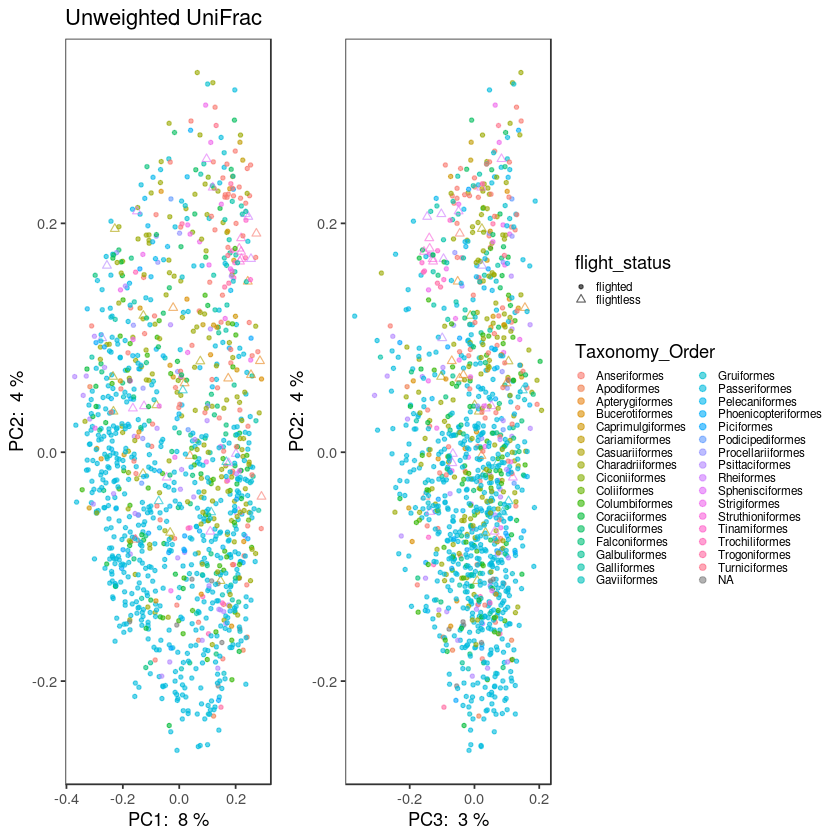

In [288]:
bird_pcoa <- b$points %>% as.data.frame %>% rownames_to_column %>%
  left_join(md, by=c('rowname'='SampleID'))


b_pc1 <- ggplot(bird_pcoa, aes(x=V1, y=V2, color=Taxonomy_Order)) +
  geom_point(aes(shape=flight_status), alpha=0.6) +
  xlab(paste("PC1: ", round(100*pcts[1]), "%")) +
  ylab(paste("PC2: ", round(100*pcts[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_shape_manual(values=c(20, 2)) +
  ggtitle("Unweighted UniFrac")

b_pc2 <- ggplot(bird_pcoa, aes(x=V3, y=V2, color=Taxonomy_Order)) +
  geom_point(aes(shape=flight_status), alpha=0.6) +
  xlab(paste("PC3: ", round(100*pcts[3]), "%")) +
  ylab(paste("PC2: ", round(100*pcts[2]), "%")) +
  theme_bw() + 
  theme(panel.grid = element_blank()) +
  scale_shape_manual(values=c(20, 2))

b_panels <- plot_grid(b_pc1 + theme(legend.position='none',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank()),
                    b_pc2 + theme(legend.position='none',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank()),
                    NULL,
                    align='vh',
                    nrow=1,
                    ncol=3)

b_legend <- get_legend(b_pc1 + theme(legend.position='right',
                                 legend.justification='right',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank(),
                                legend.text = element_text(size=7),
                                legend.key.size = unit(0.1, "in")))

bird_pc <- b_panels + draw_grob(b_legend, 2.2/3, .4, .2, .2, scale=0.5)

save_plot('../pcoa_figs/pcoa.unifrac.color-order.birds.pc1-3.pdf',
          bird_pc, 
          base_aspect_ratio = 3)

bird_pc

In [282]:
panels <- plot_grid(pc1 + theme(legend.position='none',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank()),
                    pc2 + theme(legend.position='none',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank()),
                    NULL,
                    align='vh',
                    nrow=1,
                    ncol=3)

legend <- get_legend(pc1 + theme(legend.position='right',
                                 legend.justification='right',
                                plot.background = element_blank(),
                                legend.background = element_blank(),
                                legend.box.background = element_blank(),
                                legend.text = element_text(size=7),
                                legend.key.size = unit(0.1, "in")))

bird_pc <- panels + draw_grob(legend, 2.2/3, .4, .2, .2, scale=0.5)

save_plot('../pcoa_figs/pcoa.unifrac.color-class.birds.pc1-3.pdf',
          bird_pc, 
          base_aspect_ratio = 3)
# panels + draw_grob(legend, scale = .1)
# plot_grid(panels, legend, ncol=2, rel_widths=c(1,1))

In [242]:
bird_pcoa_diet <- bird_pcoa %>% select(starts_with('Diet'),
                                           starts_with('Taxonomy'),
                                           NA.diet,
                                           is_bat,
                                           V1:V5)

In [243]:
diet_colors <- c('#a6cee3',
                 '#1f78b4',
                 '#33a02c',
                 '#b2df8a',
                 '#cab2d6',
                 '#6a3d9a',
                 '#e31a1c') 

diets <- c('Diet.Fruit',
           'Diet.Nect',
           'Diet.Plant',
           'Diet.Seed',
           'Diet.Inv',
           'Diet.Scav',
           'Diet.Meat')

In [218]:
diet_cowplot <- function(pcoa_df, pcts, cats, colors) {
    plots = list()
    for (i in seq_along(cats)) local({
        i <- i
        p <- ggplot(subset(pcoa_df, NA.diet==FALSE),
                           aes_string(x='V1', y='V2', color=cats[i])) +
                      geom_point(aes(shape=is_bat), alpha=0.6) +
                      theme_bw() + 
                      theme(panel.grid=element_blank()) +
                      scale_shape_manual(values=c(20, 2)) +
                      ggtitle(cats[i]) +
                      scale_alpha(range=c(0.04, 1)) +
                      scale_color_distiller(palette='YlGnBu') +
                      theme(legend.position = "none",
                            axis.text = element_blank(),
                            axis.title=element_blank(),
                            panel.background=element_rect(fill = "black"))
        plots[[i]] <<- p
    })
    plot_grid(plotlist=plots, nrow=3, ncol=3)
}

In [293]:
b_diet_plot <- diet_cowplot(bird_pcoa_diet,
                             pcts,
                             diets,
                             diet_colors)

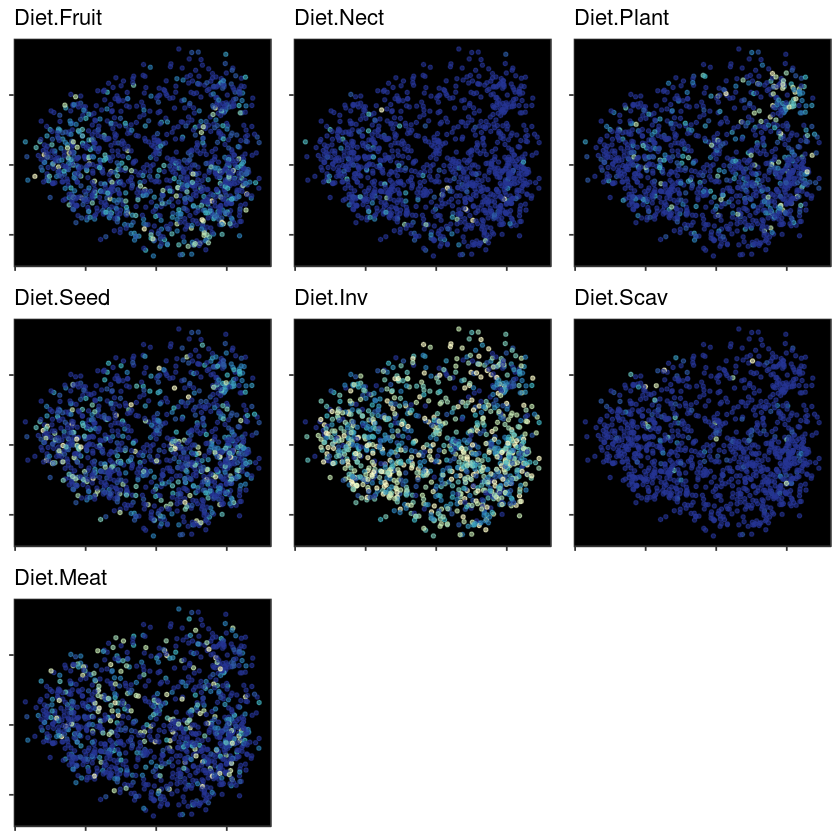

In [298]:
save_plot('../pcoa_figs/pcoa.unifrac.color-diet.birds.pdf',
          b_diet_plot, 
          base_aspect_ratio = 1,
          base_width=8,
          base_height=8)

b_diet_plot

